<a href="https://colab.research.google.com/github/AynaAraujo/Classificador_de_Coment-rios.ipynb/blob/main/Classificador_de_Coment%C3%A1rios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Sessão e leitura dos dados**

In [ ]:
# Instalando o PySpark
!pip install pyspark

In [ ]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path= '/content/drive/MyDrive/ALURA/Carreira Eng de Dados/Spark/Spark: processamento de linguagem natural/imdb-reviews-pt-br.csv'

In [ ]:
dados = spark.read.csv(path,
                       escape="\"",
                       header=True,
                       inferSchema=True)

### **Explorando os dados**



Sempre procurar entender:


*   O **tamanho** dos dados
*   Os **campos** e o *tipo*
*   O **conteúdo** em cada campo
*   A **proporção** das categorias





In [ ]:
dados.count()

49459

In [ ]:
len(dados.columns)

4

In [ ]:
#Tamanho dos dados
print(f'Nº de Linhas:{dados.count()}', f'Nº de Colunas:{len(dados.columns)}')

Nº de Linhas:49459 Nº de Colunas:4


In [ ]:
#Campos e Tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [ ]:
#Conteudo
dados.limit(99).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [ ]:
#Vendo alguns comentários
print('NEGATIVO')
print('='*30)
dados\
    .filter(dados.id == 190)\
    .select('text_pt')\
    .show(truncate = False)
print('POSITIVO')
print('='*30)
dados\
    .filter(dados.id == 12427)\
    .select('text_pt')\
    .show(truncate = False)

NEGATIVO
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [ ]:
#Contabilizando tipos de comentários
dados\
    .groupBy('sentiment')\
    .count()\
    .show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



#AULA 2 - Limpeza e Processamento

Limpeza:

1.  **Limpeza dos Dados**:
    Caracteres especiais e Espaços vazios
2.  ***StopWords**:
    Preposições, Pronomes e Verbos de Ligação
3.  **Normalização**:
    flexão de:número, grau e gênero.




In [ ]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



###WordCloud

 É uma representação visual da frequência das palavras em um texto.

 Ela é uma ferramenta valiosa para analisar e compreender a importância e a relevância de determinados termos dentro de um contexto específico.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
SEED = 101

In [ ]:
#Cria uma amostra com uma porcentagem dos dados totais
amostra = dados\
            .select('text_pt')\
            .sample(fraction = 0.1,seed = SEED)

In [ ]:
#Coloca esses dados numa lista
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [ ]:
wordcloud = WordCloud(
            background_color = 'white',
            width =1000,
            height = 600,
            collocations = False,
            prefer_horizontal =1)\
            .generate(str(tudo))

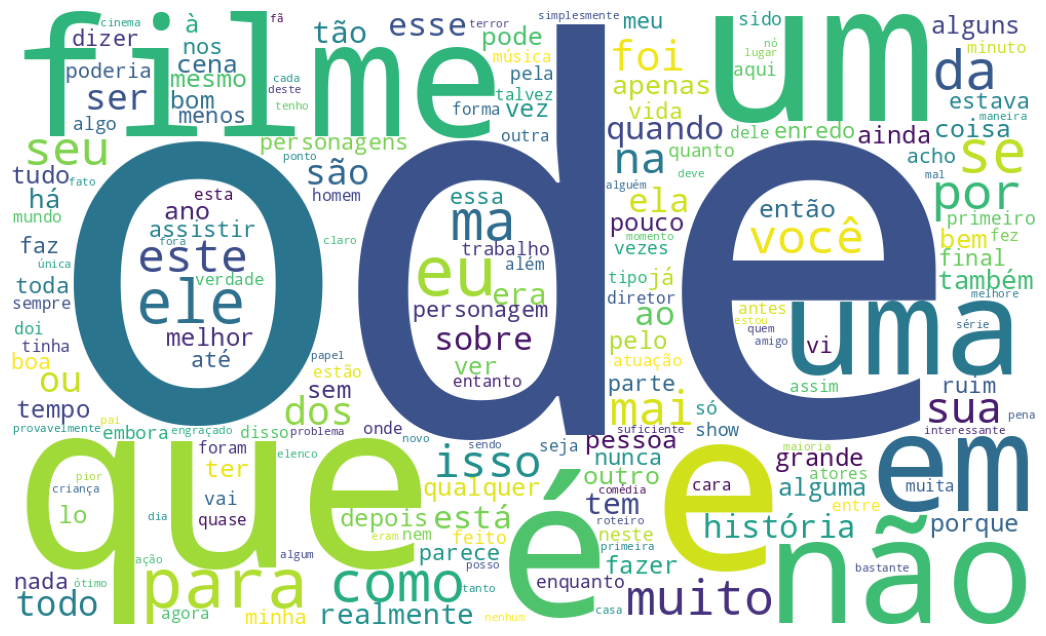

In [ ]:
plt.figure(figsize =(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##2.1 **Limpeza**: Caracteres Especiais

In [ ]:
import string

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

In [ ]:
import pyspark.sql.functions as f

In [ ]:
#Retirando Caracteres Especiais
amostra = amostra.withColumn("texto_regex",f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

In [ ]:
amostra.show()

+--------------------+--------------------+
|              textos|         texto_regex|
+--------------------+--------------------+
|        Oi, JP! Blz?|           Oi JP Blz|
|$$$\ |~ Parabéns ...|          Parabéns  |
|(#amovc #paz&amor...|      amovc pazamor |
|         "bora *_* "|              bora  |
|=>->'...``` vc fo...|  vc foi selecionad |
|{comprar: arroz; ...|comprar: arroz fe...|
|!"#$&'()*+,-./:;<...|                 :[]|
|       ana@gmail.com|         anagmailcom|
+--------------------+--------------------+



In [ ]:
#Retirando Blank Spaces com o trim()
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))

In [ ]:
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+------------------------------+
|textos                                    |texto_regex                    |texto_limpo                   |
+------------------------------------------+-------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                      |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                 |
|"bora *_* "                               |bora                           |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad             |
|{comprar: arroz; feijão e pepino} //      |comprar: arroz feijão e pepino |comprar: arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`

In [ ]:
#Retirando Caracteres Especiais
dados = dados.withColumn("texto_regex",f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

In [ ]:
dados.limit(2).show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

In [ ]:
dados.limit(2).show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##2.2 Tokenização

In [ ]:
from pyspark.ml.feature import Tokenizer

In [ ]:
tokenizer = Tokenizer(inputCol= "texto_limpo",outputCol="tokens")

In [ ]:
tokenizado = tokenizer.transform(dados)

In [ ]:
tokenizado.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|[brass, pictures,...|
|  6|A funny thing hap...|Uma co

In [ ]:
tokenizado\
    .select("texto_limpo","tokens")\
    .show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [ ]:
from pyspark.sql.types import IntegerType

In [ ]:
#Vendo quantos tokens temos
countTokens = f.udf(lambda tokens: len(tokens),IntegerType() )

In [ ]:
# ADD coluna que diz a qtd de tokens de cada texto
tokenizado\
      .select("texto_limpo","tokens")\
      .withColumn("Freq_tokens",countTokens(f.col("tokens")))\
      .show()
#note que os tokens já são tds em minusculos

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

##2.3 StopWords

###2.3.1 Testando nlkt e pyspark

In [ ]:
#Exemplo
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [ ]:
#Exemplo com nltk
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Pegando as palavras vazias do português
stop_A = stopwords.words("portuguese")

In [ ]:
stop_A

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [ ]:
#Exemplo com pyspark
from pyspark.ml.feature import StopWordsRemover

In [ ]:
stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [ ]:
stop_B

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera',
 'es

In [ ]:
tokenizer = Tokenizer(inputCol= "texto_limpo",outputCol= "tokens")

In [ ]:
tokenized =tokenizer.transform(df)

In [ ]:
#Testando com nlkt
remover = StopWordsRemover(inputCol="tokens",outputCol= "texto_final",stopWords=stop_A)
df = remover.transform(tokenized)
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [ ]:
#Testando com pyspark
remover = StopWordsRemover(inputCol="tokens",outputCol= "texto_final",stopWords=stop_B)
df = remover.transform(tokenized)
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



###2.3.2 Aplicando na Base de Dados

In [ ]:
remover = StopWordsRemover(inputCol="tokens",outputCol= "texto_final")
feature_data = remover.transform(tokenizado)

In [ ]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [ ]:
#Vendo quantos tokens foram removidos como palavras vazias
feature_data.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final")))\
                    .withColumn("Tokens_Retirados", f.col("Freq_tokens") - f.col("Fre_tokens_limpos"))\
                    .show()

+--------------------+--------------------+-----------+-----------------+----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|Tokens_Retirados|
+--------------------+--------------------+-----------+-----------------+----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|              95|
|[this, is, an, ex...|[example, majorit...|        232|              131|             101|
|[first, of, all, ...|[first, hate, mor...|        215|              111|             104|
|[not, even, the, ...|[even, beatles, w...|        308|              169|             139|
|[brass, pictures,...|[brass, pictures,...|        238|              140|              98|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|              63|
|[this, german, ho...|[german, horror, ...|        156|               74|              82|
|[being, a, longti...|[longtime, fan, j...|        136|               73|              63|

#AULA 3 - Vetorização das Palavras

##3.1 Bag of Words

In [ ]:
from pyspark.ml.feature import CountVectorizer

In [ ]:
cv =CountVectorizer(inputCol="texto_final",outputCol="CountVec")

In [ ]:
#testando com o exemplo pequeno
model = cv.fit(df)
df = model.transform(df)

In [ ]:
df\
  .select('texto_final','CountVec')\
  .show(truncate=False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



CountVec:(Argumentos)
1.  Qtd de palavras no vocabulário
2.  Posição de cada palavra no *vocabulary*
3.  Qtd de vezes que cd palavra aparece






In [ ]:
model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

###Aplicando na Base de Dados

In [ ]:
model = cv.fit(feature_data)

In [ ]:
countVectorizer_features = model.transform(feature_data)

In [ ]:
countVectorizer_features\
  .select('texto_final','CountVec')\
  .limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
model.vocabulary

['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'great',
 'bad',
 'people',
 'also',
 'dont',
 'first',
 'movies',
 'made',
 'make',
 'films',
 'way',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'never',
 'character',
 'acting',
 'love',
 'plot',
 'little',
 'best',
 'know',
 'show',
 'ever',
 'life',
 'better',
 'still',
 'say',
 'end',
 'scene',
 'man',
 'scenes',
 'something',
 'go',
 'im',
 'watching',
 'back',
 'real',
 'actors',
 'thing',
 'didnt',
 'doesnt',
 'years',
 'funny',
 'actually',
 'though',
 'makes',
 'find',
 'nothing',
 'another',
 'look',
 'lot',
 'going',
 'work',
 'new',
 'every',
 'old',
 'part',
 'cant',
 'us',
 'want',
 'pretty',
 'quite',
 'director',
 'thats',
 'cast',
 'things',
 'got',
 'seems',
 'young',
 'around',
 'take',
 'fact',
 'enough',
 'give',
 'big',
 'horror',
 'thought',
 'world',
 'ive',
 'may',
 'saw',
 'however',
 'isnt',
 'always',
 'long',
 'with

##3.2 Hashing TF

**CountVectorizer X Hashing TF**:


*  partially reversible (CountVectorizer) vs irreversible (HashingTF) - since hashing is not reversible you cannot restore original input from a hash vector.
*   memory and computational overhead - HashingTF requires only a single data scan and no additional memory beyond original input and vector



In [ ]:
from pyspark.ml.feature import HashingTF

No HashingTF você pode colocar um argumento para limitar o vocabulário

In [ ]:
hashingTF = HashingTF(inputCol="texto_final",outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HashingTF_2355b2843155

In [ ]:
HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [ ]:
HTFfeaturizedData\
    .select("texto_final","hashingTF")\
    .limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



##3.3 TF-IDF

In [ ]:
from pyspark.ml.feature import IDF

In [ ]:
idf = IDF(inputCol="hashingTF",outputCol="features")

In [ ]:
idfModel = idf.fit(HTFfeaturizedData)